In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# the library requires "optional" dependencies not available in pip for almost all basic functions, 
# but plotting for zonotopes with a small amount of generators works fine.
# Plotting Zonotopes is the only intended use in the tutorial!
!pip install pypolycontain
import pypolycontain as pp          

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:38: UserWarning: You don't have pydrake with SC

# Safe Autonomy Tutorial: Reachability of Uncertain Linear Systems Using Zonotopes




In this tutorial, we will re-implement the results of [(Girard 2005)](https://core.ac.uk/download/pdf/189205887.pdf). If anything in this tutorial is unclear, reading the paper might provide additional insight, although it is not necessary to finish the tutorial.

![](https://drive.google.com/uc?export=view&id=1UCsHWculXWysIlcxwPJ0KtF9tSw8XTYt)


`Girard, Antoine. "Reachability of uncertain linear systems using zonotopes." International Workshop on Hybrid Systems: Computation and Control. Springer, Berlin, Heidelberg, 2005.`


# Preliminiaries

Before we can start implementing the method, we should first define and understand the basic components and operations.

## Zonotopes


<div><img src="https://drive.google.com/uc?export=view&id=1_WhYzott20_CF8ley1ahsDfS0qOMBUix" width=400></div>

[Zonotopes](https://mathworld.wolfram.com/Zonotope.html) are a special class of convex polytopes. Traditionally, a zonotope is a set of points in $n$-dimensional space constructed from vectors $g_i$ by taking the sum of $x_i v_i$, where each $x_i$ is a scalar between 0 and 1. Different choices of scalars give different points, and the zonotope is the set of all such points. Equivalently, a zonotope is a Minkowski sum of a finite set of line segments. 

In this tutorial, we define a zonotope Z as a set such that:

$$Z = \Bigg\{ x \in \mathbb{R}^n \: \Bigg | \: x = c + \displaystyle\sum^{i=p}_{i=1}x_i g_i,\quad -1 \leq x_i \leq 1 \Bigg\}$$

where $c,g_1, \dots ,g_p \in \mathbb{R}^n$. We write $Z = (c, <g_1, \dots,g_p>)$. Note that a zonotope is always centrally symmetric and that the point $c$ is the **center** of $Z$. The collection of vectors $g_1,\dots,g_p$ is called the set of **generators** of $Z$.

In this tutorial, we are going to make use of two interesting properties of zonotopes presented below in order to make our computations efficient. 

But first, let's explore how a zonotope could be represented in code, using the library *pypolycontain*. The zonotope is defined by a center $c$ and three generators:

$$Z = (c,<g_1,g_2,g_3>)$$

with

*   $c = (4,0)^T$
*   $g_1 = (1,0)^T$
*   $g_2 = (0,2)^T$
*   $g_3 = (0.1,0.5)^T$



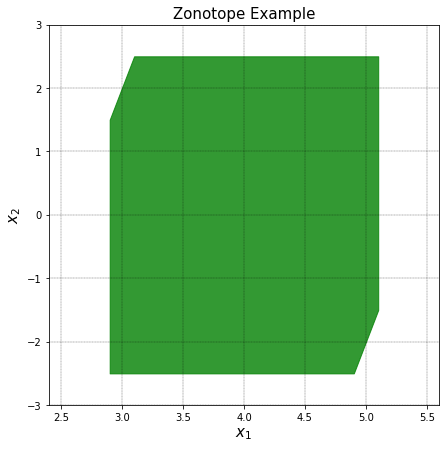

In [2]:
# center of our zonotope
c = np.array([4, 0])
# generators of our zonotope, separated in x-row and y-row i.e. the first generator is (1,0) 
g = np.array([[1, 0, 0.1], [0, 2, 0.5]])
# the center c is denoted by x in this library, don't get confused!
z = pp.zonotope(x=c, G=g)
z.color='green'

fig, ax = plt.subplots()
pp.visualize([z], title='Zonotope Example', fig=fig, ax=ax)       # pp.visualize() does all the hard work for us
fig.set_size_inches(7, 7)

### Zonotopes: Minkowski Sum

In geometry, the [Minkowski Sum](https://en.wikipedia.org/wiki/Minkowski_addition) of two sets $P$ and $Q$ is defined as:
$$P + Q = \{p+q \;|\; p \in P, q \in Q \}$$

It turns out, Zonotopes are closed under the minkowski sum. Let $Z_1 = (c_1, <g_1,\dots,g_p>)$ and $Z_2 = (c_2,<h_1,\dots,h_q>)$ be two zonotopes. 

$$Z_1 + Z_2 = (c_1+c_2, <g_1,\dots,g_p,h_1,\dots,h_q>)$$

In practice, this simply means we can compute the Minkowski sum of two zonotopes by adding the centers and appending the generators.

#### Exercise 1

Let's try this out for ourselves. Compute and visualize the minkowski sum of two zonotopes by adding the centers and appending the generators! Solve the exercise by changing the annotated lines:

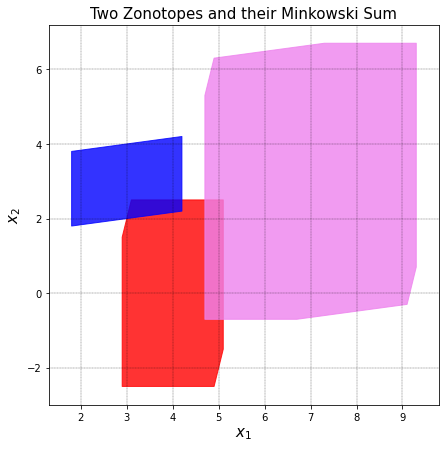

In [3]:
# two zonotopes
c1 = np.array([4, 0])
g1 = np.array([[1, 0, 0.1], [0, 2, 0.5]])
z1 = pp.zonotope(x=c1, G=g1)
z1.color='red'

c2 = np.array([3, 3])
g2 = np.array([[0, 1.2], [1, 0.2]])
z2 = pp.zonotope(x=c2, G=g2)
z2.color='blue'

# their minkowski sum

# PUT YOUR CODE HERE
cs = c1 + c2
gs = np.append(g1, g2, axis=1)

zs = pp.zonotope(x=cs, G=gs)
zs.color='violet'


fig, ax = plt.subplots()
pp.visualize([z1, z2, zs], title='Two Zonotopes and their Minkowski Sum', ax=ax, fig=fig)
fig.set_size_inches(7, 7)

### Zonotopes: Linear Transformation

Zonotopes are closed under linear transformation. Let $\mathcal{L}$ be a linear map and $Z = (c, <g_1,\dots,g_p>)$ be a zonotope. Then the linear transformation can simply be expressed as $\mathcal{L}Z = (\mathcal{L}c, <\mathcal{L}g_1, \dots, \mathcal{L}g_p>)$.

#### Exercise 2

In similar fashion to above: Compute and visualize the scalar multiplication of a zonotope $Z$ with some scalar factor $n \in N$:

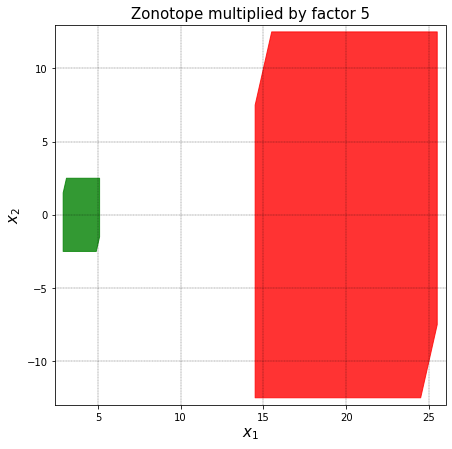

In [4]:
# our starting zonotope
c = np.array([4, 0])
g = np.array([[1, 0, 0.1], [0, 2, 0.5]])
z = pp.zonotope(x=c, G=g)
z.color='green'

#simple scalar multiplication example
# PUT YOUR CODE HERE
factor = 5
cL = factor * c
gL = factor * g

zL = pp.zonotope(x=cL, G=gL)
zL.color='red'

fig, ax = plt.subplots()
pp.visualize([z, zL], title='Zonotope multiplied by factor %i'%factor, fig=fig, ax=ax)
fig.set_size_inches(7, 7)

### Zonotopes: Reduction - Interval Hull

Since every Minkowski sum increases number of generators in resulting zonotopes, ongoing computations can lead to zonotopes become to memory-intensive too handle. A reduction of the number of generators by overapproximation of the zonotope through a simpler one might be useful later on.

Multiple methods for such a reduction step exists, but we will only cover the simplest method in this tutorial, the **intervall hull** method.

With this method, an n-dimensional zonotope with p generators will be overapproximated by an n-dimensional zonotope with n generators.

In 2d, the reduction step is quite simple and reduces any zonotope to a zonotope represented by a 2D diagonal matrix of the following form:

\begin{bmatrix}
\displaystyle\sum^{p}_{j=1}|g_j^1| & 0 \\
0 & \displaystyle\sum^{p}_{j=1}|g_j^2|
\end{bmatrix}

where $g_j^i$ is the i-th value of the generator $g_j$ of the zonotope and p is the number of generators the zonotope has. **Note that each column represents a generator**. So essentially, by summing the absolute values of all the generators for a certain zonotope, we can compute the overapproximation.

#### Exercise 3

Try implementing it yourself! The result should be a rectangle tightly fitting the given zonotope.

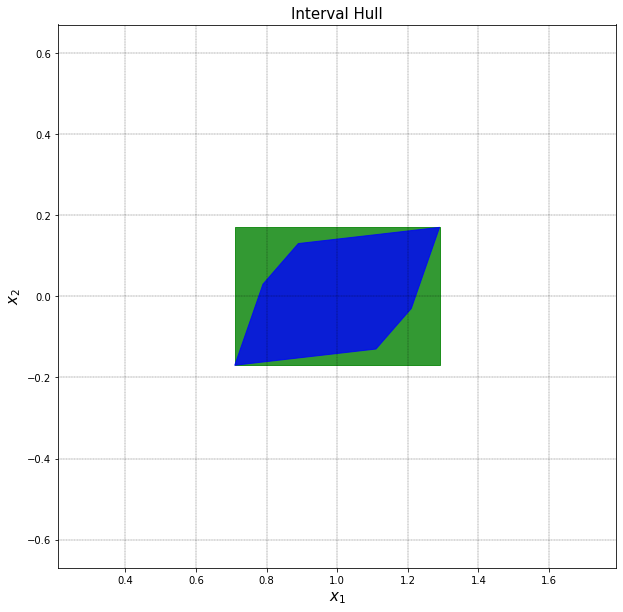

In [5]:
# our starting zonotope with 3 generators
z_c = np.array([1, 0])
z_g = np.array([[0.2, 0.04, 0.05], [0.02, 0.1, 0.05]])
z = pp.zonotope(x=z_c, G=z_g)
z.color = 'blue'

# reduction step by interval hull
# PUT YOUR CODE HERE
ih_c = z_c
ih_g = np.array([[np.sum(np.abs(z_g[0])), 0], [0, np.sum(np.abs(z_g[1]))]])

ih = pp.zonotope(x=ih_c, G=ih_g)
ih.color = 'green'

fig, ax = plt.subplots()
pp.visualize([ih, z], title='Interval Hull', fig=fig, ax=ax)
fig.set_size_inches(10, 10)

## Uncertain Linear Systems

In this tutorial, we consider uncertain linear dynamical systems defined through

$$x'(t) = Ax(t) + u(t), \quad ||u(t)|| < \mu$$

where 


*   $x(t) \in \mathbb{R}^n$ is the state  vector of the system,
*   $A \in \mathbb{R}^{n \times n}$ is a constant matrix,
*   $u(t) \in \mathbb{R}^n$ is a disturbance bounded by $\mu$


 and $||.||$ denotes the infinity norm on $\mathbb{R}^n: ||x|| = \max_{i=1}^{\, i=n}|x_i|$.


 Examples for such a system include, but are not limited to:

*   a pendulum
*   car suspension through springs
*   ...






In [6]:
A = np.array([[-1., -4.], [4., -1.]])
mu = 0.05

# Approximation of Reachable Sets

In this example, we will start computations from an inital set of positions, defined through the zonotope $I$.

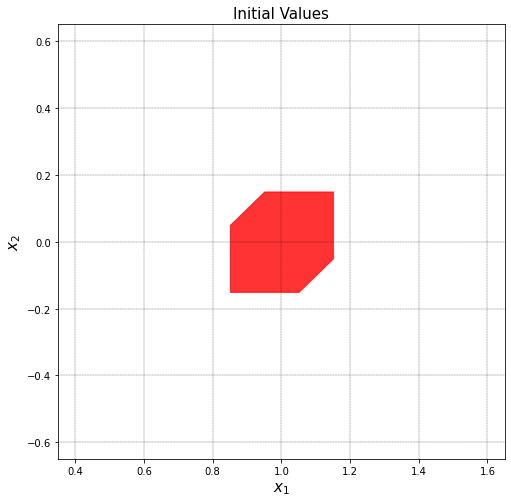

In [7]:
init_c = np.array([1, 0])                                          # center of the initial zonotope
init_g = np.array([[0.1, 0, 0.05], [0, 0.1, 0.05]])                # generators of the initial zonotope 

init = pp.zonotope(x=init_c, G=init_g)
init.color = 'red'
pp.visualize([init], title='Initial Values')


A reachable set of a system at time t reachable from the initial set of states $I$ can be expressed as:

$\Phi_t(I) = y \in \mathbb{R}^n : \exists x$ solution of linear dynamical system equation, $, x(0) \in I \land x(t)=y$.

What this means in words, is that if there exists a solution of the system such that an initial value can be used to reach that solution, then that solution is deemed to be reachable, i.e. part of the reachable set.

To compute the reachable set within a certain interval $[\underline t,\overline t]$. We take the union of all the reachable sets within this interval in the follwing manner:

$$ R_{[\underline t,\overline t]}(I) = \underset{t\in [\underline t,\overline t]}{\bigcup}\Phi_t(I)$$

If we simplify our problem for only positive intervals, which is usually an applicable simplificiation because only positive intervals are needed to predict the future, we can obtain a simpler reachable set. Here, we set N to be the number of iterations in the future to check for reachability.

$$ R_{[0,T]}(I) = \bigcup_{i=0}^{i=N-1}R_{[i*\frac{T}{N},(i+1)*\frac{T}{N}]}(I)$$





In [8]:
t = 10            # time interval [0,T] that is observed
r = 0.02          # discrete time step size
n = int(t / r)    # amount of time steps

To be able to determine reachability in a simpler manner, we rely on over-approximations of the reachable set. Over-approximation means that the reachable set you get is larger than the exact reachable set. This is useful to determine if no unsafe states are reached, for example. If no unsafe states are reached in an over-approximation, then it is guaranteed that no unsafe states are reached in the exact reachable set.


The over-approximation of the reachable set of a system is defined using the following formula:

$$\Phi_r(Z)\subseteq e^{rA}Z+\Box(\beta_r)$$

where $$\beta_r=\frac{e^{r||A||}-1}{||A||}\mu$$

and $$\Box(\beta_r) = \{x\in \mathbb{R}^n \;|\; ||x|| \leq \beta_r\}.$$ 

From the definition of the infinity-norm, we can conclude that this set is actually a hypercube and can therefore be represented by a zonotope with center $(0,0)^T$ and two generators $g_1 = (\beta_r, 0)^T, g_2= (0, \beta_r)^T$. For demonstration purposes, the 2D version of $\Box(1)$ is displayed below.

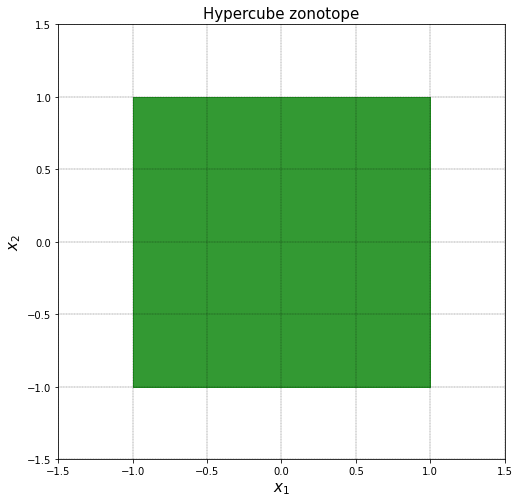

In [9]:
unit_cube = np.array([[1, 0], [0, 1]])
C = pp.zonotope(G=unit_cube)
pp.visualize([C], title=r'Hypercube zonotope')

Next, we want to obtain a conservative approximation of the reachable set 
$ R_{[0,r]}(Z)$ for a given zonotope $Z$. 

$$ R_{[0,r]}(Z)\subseteq (\underset{t\in [0,r]}{\bigcup})e^{tA}Z)+\Box(\beta_r)$$

The issue with this approach is that it uses the convex hull of $Z$ and $e^{rA}Z$, which is not a zonotope. Instead, the following approximation can be made which is very simple to compute:
$P_0=(\frac{c+e^{rA}c}{2},<\frac{g_1+e^{rA}g_1}{2},..., \frac{g_p+e^{rA}g_p}{2},\frac{c-e^{rA}c}{2}, \frac{g_1-e^{rA}g_1}{2},...,\frac{g_p-e^{rA}g_p}{2}>)$
where $P_0$ is a zonotope that can be used to compute the conservative approximation using the following equation:

$$ R_{[0,r]}(Z)\subseteq P_0+\Box(\alpha_r+\beta_r)=Q_0$$

with $$\alpha_r=(e^{r||A|}-1-r||A||)sup_{x\in Z}||x||.$$

The process is graphically explained in the following figure. For further explanation and proof, please refer to the paper.

![](https://drive.google.com/uc?export=view&id=14Pm-CRbdEpSYeAx4adAJrKQRfE9QQBbm)

#### Exercise 4 - P0 and Q0

Now let's try to compute the first step of the reachable sets, $P_0$ and $Q_0$! For your convience, the code below already has all of the derived constants, but computation for the zonotopes is missing. Fill them in like described above!

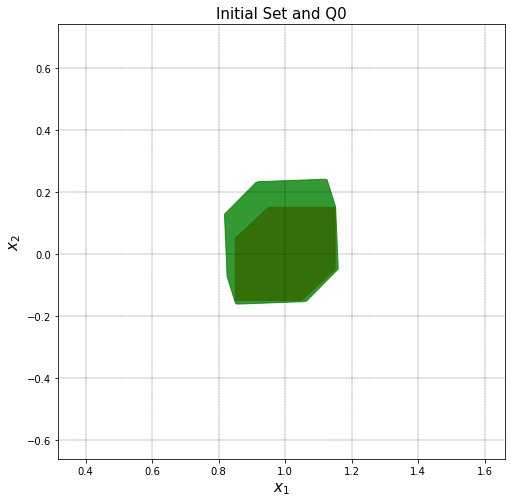

In [10]:
# derived constants from pseudo code
A_norm = np.linalg.norm(A, np.inf)
e_ra = np.array(expm(r*A))

sup_ig = max(np.linalg.norm(g, np.inf) for g in init_g.T)      # iterate over columns, which are the generators of  the initial zonotope
alpha = (np.exp(r*A_norm) - 1 - r*A_norm) * sup_ig
beta = ((np.exp(r*A_norm) - 1) / A_norm) * mu

beta_box_g = np.array([[beta, 0], [0, beta]]).reshape(2, 2)
alpha_beta_box_g = np.array([[alpha+beta, 0], [0, alpha+beta]]).reshape(2, 2)

# PUT YOUR CODE HERE
# p0 computations - center vector
p0_c = (init_c + e_ra @ init_c) / 2

# p0 computations - generators
p0_g_part_1 = (init_g + e_ra @ init_g) / 2
p0_g_part_2 = (init_c - e_ra @ init_c) / 2
p0_g_part_2 = p0_g_part_2[..., np.newaxis]
p0_g_part_3 = (init_g - e_ra @ init_g) / 2
p0_g = np.hstack((p0_g_part_1, p0_g_part_2, p0_g_part_3))

#TODO: fill the values of p0_g

q0_c = p0_c # alpha_beta_box has center 0
q0_g = np.append(p0_g, alpha_beta_box_g, axis=1)


# lists to store the q generators and centers
q_g = []
q_c = []
# q0 computations
q_c.append(q0_c)
q_g.append(q0_g)

pp.visualize([init, pp.zonotope(x=q_c[0], G= q_g[0]) ], title=r'Initial Set and Q0')

#### Exercise 5 - The Loop

Afterwards, we need to compute the zonotopes representing the reachable sets originating from previous reachable sets up to time $T$. To do this, we iterate over the number of time steps, using the following equations to compute the reachable zonotope of the current time step from the previous reachable set:

$P_i=e^{rA}Q_{i-1}$

$Q_i=P_i+\Box(\beta_r)$

Note that due to the minkowski sum, the number of generators of $Q_i$ increases by 2 with each time step.

In [11]:
# PUT YOUR CODE HERE
# loop to compute pi and qi from predecessors
for i in range(1, n):
    pi_c = e_ra @ q_c[-1]
    pi_g = e_ra @ q_g[-1]

    qi_c = pi_c
    qi_g = np.append(pi_g, beta_box_g, axis=1)

    q_c.append(qi_c)
    q_g.append(qi_g)

As mentioned previously, with iteration of the reachable set computation, the number of generators for the zonotope being computed increases by 2. This will result in zonotopes with large numbers of generators, even for systems with relatively small number of steps.

Zonotopes with large numbers of generators pose efficiency questions and are quite difficult to plot (pypolycontains requires additional dependencies starting from 13 generators), so a reduction step, which approximates the zonotope with a rectangle, can bring the number of generators down to 2, which is highlighted earlier in the tutorial. 

NOTE:
In this tutorial, this will **only affect the visualization** of the results, as performance is not an issue in this simple example. For longer or more realistic computations, it might prove necessary to compute the reduced overapproximation in every iteration of the loop and continue computing following reachable sets based on that.



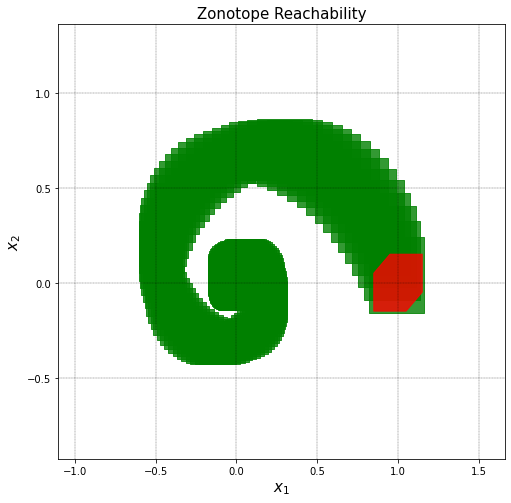

In [12]:
zonotopes_to_plot = []                                          # we will use this to store our results

for i in range(0, n):
    # reduction step by interval hull
    qi_g_reduced = np.zeros((2, 2))
    for index, row in enumerate(q_g[i]):
        qi_g_reduced[index, index] = np.sum(np.abs(row))

    # add the reduced zonotope to the plot list
    zonotopes_to_plot.append(pp.zonotope(x=q_c[i], G=qi_g_reduced))

zonotopes_to_plot.append(init)                                  # append the initial set last so it is printed on top

fig, ax = plt.subplots()
pp.visualize(zonotopes_to_plot, title='Zonotope Reachability', fig=fig, ax=ax)
plt.show()